# Viscosity-based filtering with vector Laplacians

In this tutorial, we use **viscosity-based filters** to filter a velocity field $(u,v)$ on a curvilinear grid. The viscosity-based filter uses a **vector Laplacian** (rather than a scalar Laplacian).

In [1]:
import gcm_filters
import numpy as np
import xarray as xr

Here are all grid types that we have available.

In [2]:
list(gcm_filters.GridType)

[<GridType.REGULAR: 1>,
 <GridType.TRANSFORMED_TO_REGULAR: 2>,
 <GridType.REGULAR_WITH_LAND: 3>,
 <GridType.TRANSFORMED_TO_REGULAR_WITH_LAND: 4>,
 <GridType.IRREGULAR_WITH_LAND: 5>,
 <GridType.TRIPOLAR_TRANSFORMED_TO_REGULAR_WITH_LAND: 6>,
 <GridType.TRIPOLAR_POP_WITH_LAND: 7>,
 <GridType.VECTOR_C_GRID: 8>]

From this list, only the `VECTOR_C_GRID` has a vector Laplacian. All other grid types operate with scalar Laplacians. As the name suggests, the `VECTOR_C_GRID` works for vector fields that are defined on an **Arakawa C-grid**, where the u-component is defined at the center of the eastern cell edge, and the v-component at the center of the northern cell edge.

## 0.1 degree MOM6 data

We are working with MOM6 data from a 0.1 degree simulation on an Arakawa **C-grid**. The `VECTOR_C_GRID` type is therefore suitable for our data!

In [3]:
import requests
r = requests.get('https://ndownloader.figshare.com/files/28278078')
with open('MOM6_surf_vels.0.1degree.nc', 'wb') as fp:
    fp.write(r.content)    
ds = xr.open_dataset('MOM6_surf_vels.0.1degree.nc', decode_times=False)
ds

<xarray.Dataset>
Dimensions:   (nv: 2, time: 31, xh: 3600, xq: 3600, yh: 2400, yq: 2400)
Coordinates:
  * xq        (xq) float64 -109.9 -109.8 -109.7 -109.6 ... -110.2 -110.1 -110.0
  * nv        (nv) float64 1.0 2.0
  * time      (time) float64 7.666e+03 7.666e+03 ... 7.694e+03 7.696e+03
  * xh        (xh) float64 -109.9 -109.8 -109.8 -109.7 ... -110.2 -110.2 -110.1
  * yh        (yh) float64 -78.47 -78.43 -78.39 -78.35 ... 89.88 89.92 89.97
  * yq        (yq) float64 -78.45 -78.41 -78.37 -78.32 ... 89.85 89.9 89.95 90.0
Data variables:
    SSU       (yh, xq) float32 ...
    SSV       (yq, xh) float32 ...
    geolon    (yh, xh) float32 ...
    geolon_u  (yh, xq) float32 ...
    geolon_v  (yq, xh) float32 ...
    geolat    (yh, xh) float32 ...
    geolat_u  (yh, xq) float32 ...
    geolat_v  (yq, xh) float32 ...
    dxT       (yh, xh) float32 ...
    dyT       (yh, xh) float32 ...
    dxCu      (yh, xq) float32 ...
    dyCu      (yh, xq) float32 ...
    dxCv      (yq, xh) float32 ...
    dyCv      (yq, xh) float32 ...
    wet       (yh, xh) float32 ...
    wet_c     (yq, xq) float32 ...
    wet_u     (yh, xq) float32 ...
    wet_v     (yq, xh) float32 ...
    area_t    (yh, xh) float32 ...
    area_u    (yh, xq) float32 ...
    area_v    (yq, xh) float32 ...
    dxBu      (yq, xq) float64 ...
    dyBu      (yq, xq) float64 ...

## Preparing the grid info
These are the grid variables that our vector Laplacian needs to know.

In [4]:
gcm_filters.required_grid_vars(gcm_filters.GridType.VECTOR_C_GRID)

['wet_mask_t',
 'wet_mask_q',
 'dxT',
 'dyT',
 'dxCu',
 'dyCu',
 'dxCv',
 'dyCv',
 'dxBu',
 'dyBu',
 'area_u',
 'area_v',
 'kappa_iso',
 'kappa_aniso']

In the next cell, we swap the `xq` and `yq` dimensions to `xh` and `yh`. It is important to note that we do this swapping only because `gcm-filters` requires all input variables to have the same dimensions, even though the Laplacian assumes that the grid variables are staggered. In other words, we do *not* actually move the data to `xh`, `yh` grid points!

In [5]:
# grid info centered at T-points
wet_mask_t = ds.wet
dxT = ds.dxT
dyT = ds.dyT
# grid info centered at U-points
dxCu = ds.dxCu.swap_dims({"xq": "xh"})
dyCu = ds.dyCu.swap_dims({"xq": "xh"})
area_u = dxCu * dyCu
# grid info centered at V-points
dxCv = ds.dxCv.swap_dims({"yq": "yh"})
dyCv = ds.dyCv.swap_dims({"yq": "yh"})
area_v = dxCv * dyCv
# grid info centered at vorticity points
wet_mask_q = ds.wet_c.swap_dims({"xq": "xh", "yq": "yh"})
dxBu = ds.dxBu.swap_dims({"xq": "xh", "yq": "yh"})
dyBu = ds.dyBu.swap_dims({"xq": "xh", "yq": "yh"})

Next, we compute the minimum and maximum grid spacing.

In [6]:
dx_min = min(dxT.where(wet_mask_t).min(), dyT.where(wet_mask_t).min())
dx_min = dx_min.values
dx_min

array(2245.78271484)

In [7]:
dx_max = max(dxT.max(), dyT.max(), dxCu.max(), dyCu.max(), dxCv.max(), dyCv.max(), dxBu.max(), dyBu.max())
dx_max = dx_max.values
dx_max

array(11260.51171875)

## Viscosity-based filtering with fixed length scale

First, we want to filter velocity with a **fixed filter length scale of 100 km**. That is, we use a filter that attempts to remove scales smaller than 100 km. 

In [8]:
filter_scale = 100000

Since we don't want to vary the filter scale spatially and we are happy with an isotropic filter, we set `kappa_iso` equal to 1 and `kappa_aniso` equal to 0 over the full domain.

In [9]:
kappa_iso = xr.ones_like(dxT)
kappa_aniso = xr.zeros_like(dyT)

### Creating the filter

We now create our filter.

In [10]:
filter_visc_100km = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.VECTOR_C_GRID,
    grid_vars={
        'wet_mask_t': wet_mask_t, 'wet_mask_q': wet_mask_q,
        'dxT': dxT, 'dyT': dyT, 
        'dxCu': dxCu, 'dyCu': dyCu, 'area_u': area_u, 
        'dxCv': dxCv, 'dyCv': dyCv, 'area_v': area_v,
        'dxBu': dxBu, 'dyBu': dyBu,
        'kappa_iso': kappa_iso, 'kappa_aniso': kappa_aniso
    }
)
filter_visc_100km

Filter(filter_scale=100000, dx_min=array(2245.78271484), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=49, grid_type=<GridType.VECTOR_C_GRID: 8>)

### Filtering velocity

We now filter our velocity vector field lazily. In contrast to the diffusion-based filters, the viscosity-based filter **takes a vector field** (here: $(u,v)$) **as input** and **returns a vector field**. 

In [11]:
ds_tmp = xr.Dataset()  # temporary dataset with swapped dimensions
ds_tmp['u'] = ds['SSU']
ds_tmp['v'] = ds['SSV']
ds_tmp['u'] = ds_tmp['u'].swap_dims({'xq':'xh'})
ds_tmp['v'] = ds_tmp['v'].swap_dims({'yq':'yh'})

In [12]:
ds_tmp.u

<xarray.DataArray 'u' (yh: 2400, xh: 3600)>
[8640000 values with dtype=float32]
Coordinates:
  * yh       (yh) float64 -78.47 -78.43 -78.39 -78.35 ... 89.88 89.92 89.97
  * xh       (xh) float64 -109.9 -109.8 -109.8 -109.7 ... -110.2 -110.2 -110.1
Attributes:
    long_name:      Sea Surface Zonal Velocity
    units:          m s-1
    cell_methods:   yh:mean xq:point time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  none

In [13]:
ds_tmp.v

<xarray.DataArray 'v' (yh: 2400, xh: 3600)>
[8640000 values with dtype=float32]
Coordinates:
  * yh       (yh) float64 -78.47 -78.43 -78.39 -78.35 ... 89.88 89.92 89.97
  * xh       (xh) float64 -109.9 -109.8 -109.8 -109.7 ... -110.2 -110.2 -110.1
Attributes:
    long_name:      Sea Surface Meridional Velocity
    units:          m s-1
    cell_methods:   yq:point xh:mean time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  none

In [14]:
%time (u_filtered, v_filtered) = filter_visc_100km.apply_to_vector(ds_tmp.u, ds_tmp.v, dims=['yh', 'xh'])

CPU times: user 23.6 s, sys: 16.7 s, total: 40.3 s
Wall time: 40.5 s


We now swap back the dimensions.

In [15]:
ds_tmp['u_filtered'] = u_filtered
ds_tmp['u_filtered'] = ds_tmp['u_filtered'].swap_dims({'xh':'xq'})

ds_tmp['v_filtered'] = v_filtered
ds_tmp['v_filtered'] = ds_tmp['v_filtered'].swap_dims({'yh':'yq'})

### Plotting

In [16]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'font.size': 16}
pylab.rcParams.update(params)
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

To be able to plot unfiltered and filtered fields using true longitude and latitude, we need to make geolon/geolat coordinates of our xarray.Datasets.

In [17]:
u = ds['SSU'].where(ds.wet_u).assign_coords({'geolat': ds['geolat_u'], 'geolon': ds['geolon_u']})
v = ds['SSV'].where(ds.wet_v).assign_coords({'geolat': ds['geolat_v'], 'geolon': ds['geolon_v']})

In [18]:
u_filtered = ds_tmp.u_filtered.where(ds.wet_u).assign_coords({'geolat': ds['geolat_u'], 'geolon': ds['geolon_u']})
v_filtered = ds_tmp.v_filtered.where(ds.wet_v).assign_coords({'geolat': ds['geolat_v'], 'geolon': ds['geolon_v']})

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


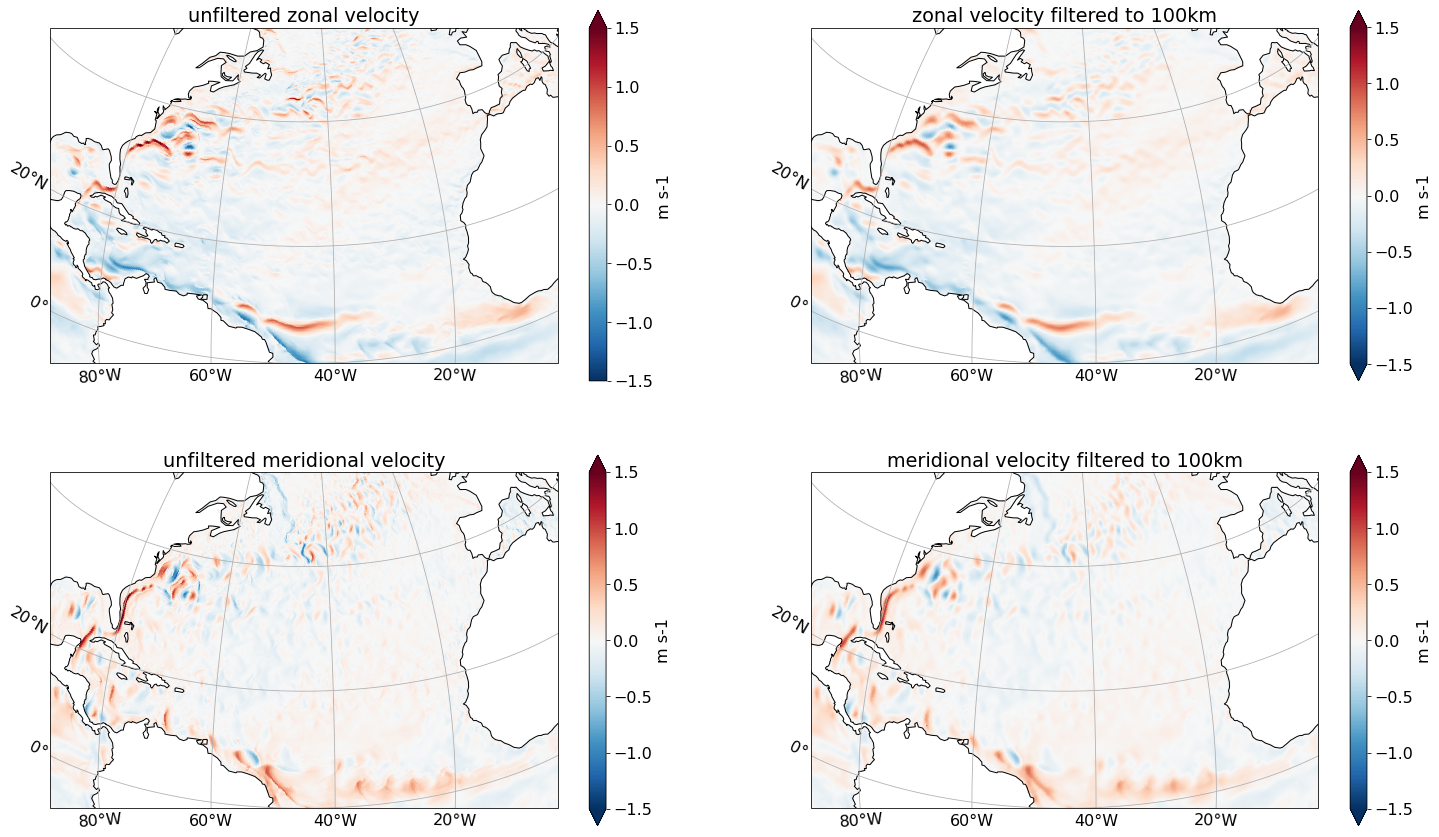

In [19]:
vmax = 1.5
central_lon = -45
central_lat = 30

fig,axs = plt.subplots(2,2,figsize=(25,15),subplot_kw={'projection':ccrs.Orthographic(central_lon, central_lat)})

u.plot(
    ax=axs[0,0], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)
v.plot(
    ax=axs[1,0], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)
u_filtered.plot(
    ax=axs[0,1], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)
v_filtered.plot(
    ax=axs[1,1], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)

axs[0,0].set(title='unfiltered zonal velocity')
axs[0,1].set(title='zonal velocity filtered to 100km')
axs[1,0].set(title='unfiltered meridional velocity')
axs[1,1].set(title='meridional velocity filtered to 100km')

for ax in axs.flatten():
    ax.coastlines()
    ax.set_extent([-90, 0, 0, 50], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-80,-60,-40,-20])
    gl.ylocator = mticker.FixedLocator([0,20,40,60])
    gl.top_labels = False
    gl.right_labels = False


## Viscosity-based filtering with fixed filter factor

In our second example, we want to filter velocity with a **fixed filter factor of 10**. That is, our goal is to use a filter that removes scales smaller than **10 times the local grid scale**. 
The fixed factor filter is a **spatially-varying & anisotropic filter**. Consistent with the MOM6 implementation of anisotropic viscosity, the conventions for the `VECTOR_C_GRID` Laplacian are:
* `kappa_iso` is the isotropic viscosity,
* `kappa_aniso` is the additive anisotropy that is aligned with x-direction,

resulting in `kappa_x = kappa_iso + kappa_aniso` and `kappa_y = kappa_iso`. Anisotropy in an arbitrary direction (not aligned with the grid directions) is not yet implemented for `VECTOR_C_GRID`, but could be added mimicking the implementation in MOM6 (following [Smith and McWilliams, 2003](https://www.sciencedirect.com/science/article/pii/S1463500302000161?via%3Dihub)). 

To filter with a fixed factor of 10, we need the filter scale to be equal to **ten times $dx_{max}$**, together with $\kappa_x = dx^2/dx_{max}^2$ and $\kappa_y = dy^2/dx_{max}^2$, where $dx_{max}$ is the minimum grid spacing in the domain. (See the [Filter Theory](https://gcm-filters.readthedocs.io/en/latest/theory.html) or Section 2.6 in [Grooms et al. (2021)](https://www.essoar.org/doi/10.1002/essoar.10506591.1) for more details).

In [20]:
filter_scale = 10 * dx_max
kappa_iso = dyCv * dyCv / (dx_max * dx_max)
kappa_aniso = dxCu * dxCu / (dx_max * dx_max) - dyCv * dyCv / (dx_max * dx_max)

The filter needs: $0 < \kappa_{iso} \leq 1$ and $0 < \kappa_{iso} + \kappa_{aniso} \leq 1$. These requirements are satisfied as shown in the next plot.

In [21]:
kappa_iso = kappa_iso.where(wet_mask_t).assign_coords({'geolat': ds['geolat'], 'geolon': ds['geolon']})
kappa_aniso = kappa_aniso.where(wet_mask_t).assign_coords({'geolat': ds['geolat'], 'geolon': ds['geolon']})

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


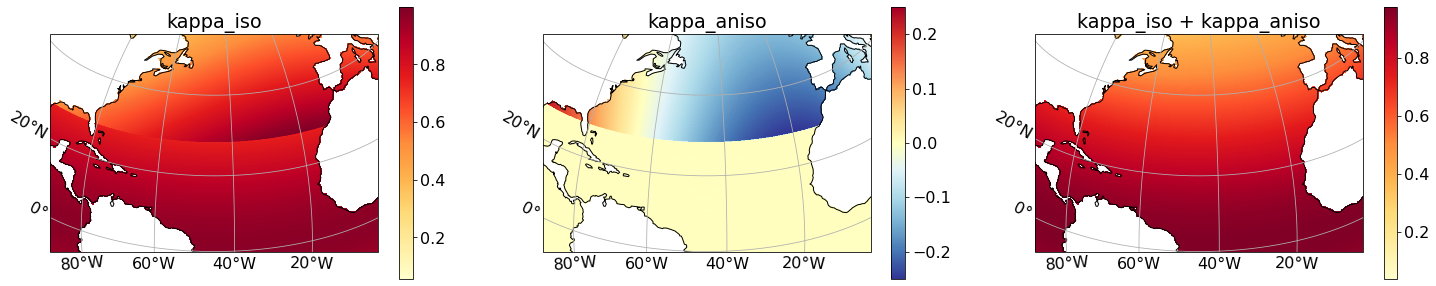

In [22]:
fig,axs = plt.subplots(1,3,figsize=(25,5),subplot_kw={'projection':ccrs.Orthographic(central_lon, central_lat)})

kappa_iso.plot(
    ax=axs[0], x='geolon', y='geolat', cmap='YlOrRd', cbar_kwargs={'label': ''},
    transform=ccrs.PlateCarree()
)
kappa_aniso.plot(
    ax=axs[1], x='geolon', y='geolat', cmap='RdYlBu_r', cbar_kwargs={'label': ''},
    transform=ccrs.PlateCarree()
)
(kappa_iso + kappa_aniso).plot(
    ax=axs[2], x='geolon', y='geolat', cmap='YlOrRd', cbar_kwargs={'label': ''},
    transform=ccrs.PlateCarree()
)

axs[0].set(title='kappa_iso')
axs[1].set(title='kappa_aniso')
axs[2].set(title='kappa_iso + kappa_aniso')

for ax in axs.flatten():
    ax.coastlines()
    ax.set_extent([-90, 0, 0, 50], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-80,-60,-40,-20])
    gl.ylocator = mticker.FixedLocator([0,20,40,60])
    gl.top_labels = False
    gl.right_labels = False


We now create our fixed factor filter.

In [23]:
filter_fac10 = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.VECTOR_C_GRID,
    grid_vars={'wet_mask_t': wet_mask_t, 'wet_mask_q': wet_mask_q,
                'dxT': dxT, 'dyT': dyT, 
               'dxCu': dxCu, 'dyCu': dyCu, 'area_u': area_u, 
               'dxCv': dxCv, 'dyCv': dyCv, 'area_v': area_v,
               'dxBu': dxBu, 'dyBu': dyBu,
               'kappa_iso': kappa_iso, 'kappa_aniso': kappa_aniso
              }
)
filter_fac10

Filter(filter_scale=112605.1171875, dx_min=array(2245.78271484), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=56, grid_type=<GridType.VECTOR_C_GRID: 8>)

We filter surface velocities with the fixed factor filter.

In [24]:
%time (u_filtered_fac10, v_filtered_fac10) = filter_fac10.apply_to_vector(ds_tmp.u, ds_tmp.v, dims=['yh', 'xh'])

CPU times: user 27.4 s, sys: 19.3 s, total: 46.7 s
Wall time: 46.8 s


In [25]:
ds_tmp['u_filtered_fac10'] = u_filtered_fac10
ds_tmp['u_filtered_fac10'] = ds_tmp['u_filtered_fac10'].swap_dims({'xh':'xq'})

ds_tmp['v_filtered_fac10'] = v_filtered_fac10
ds_tmp['v_filtered_fac10'] = ds_tmp['v_filtered_fac10'].swap_dims({'yh':'yq'})

In [26]:
u_filtered_fac10 = ds_tmp['u_filtered_fac10'].where(ds.wet_u).assign_coords({'geolat': ds['geolat_u'], 'geolon': ds['geolon_u']})
v_filtered_fac10 = ds_tmp['v_filtered_fac10'].where(ds.wet_v).assign_coords({'geolat': ds['geolat_v'], 'geolon': ds['geolon_v']})

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


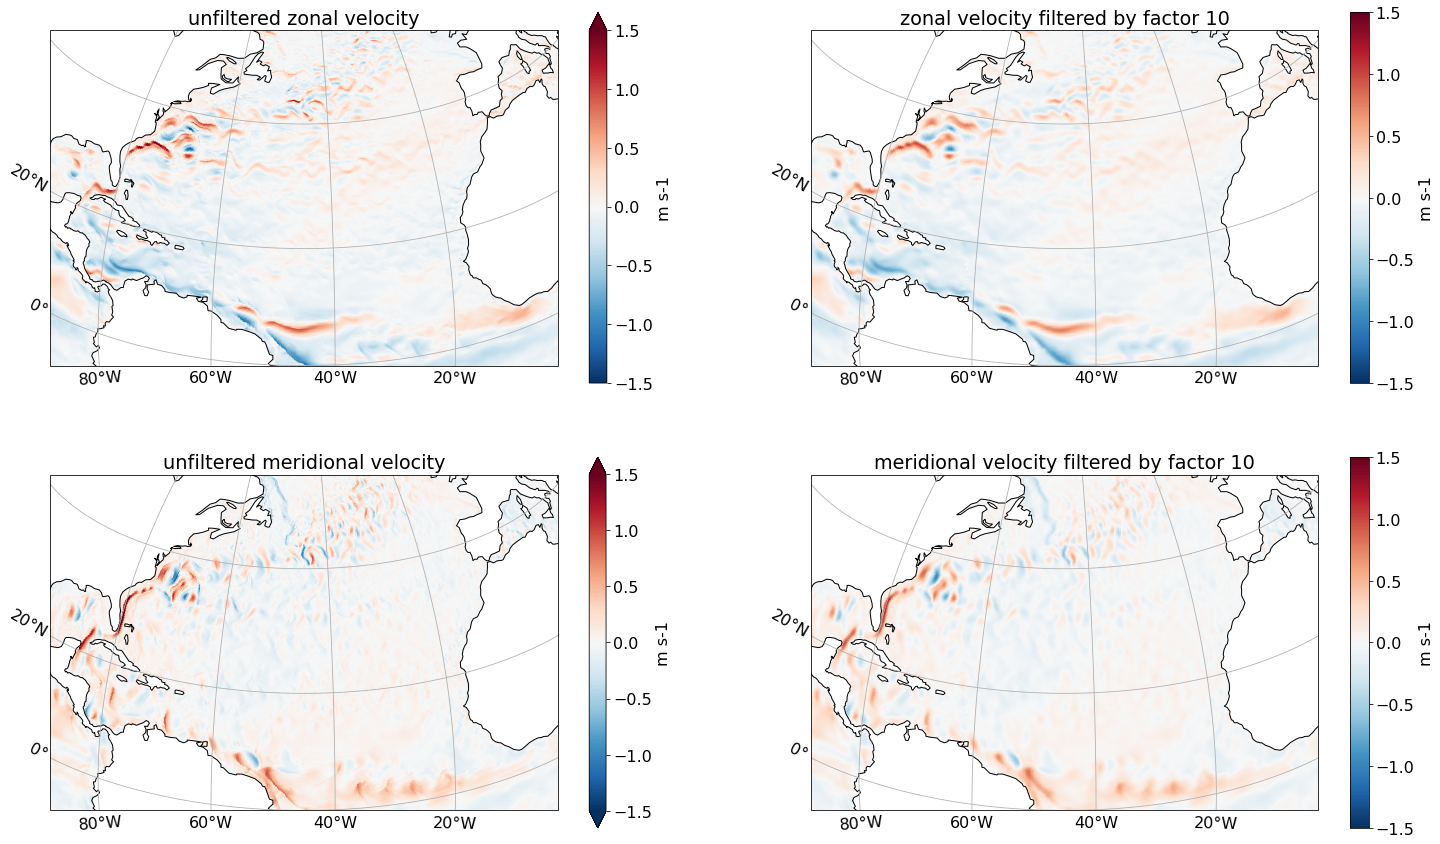

In [27]:
vmax = 1.5
central_lon = -45
central_lat = 30

fig,axs = plt.subplots(2,2,figsize=(25,15),subplot_kw={'projection':ccrs.Orthographic(central_lon, central_lat)})

u.plot(
    ax=axs[0,0], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)
v.plot(
    ax=axs[1,0], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)
u_filtered_fac10.plot(
    ax=axs[0,1], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)
v_filtered_fac10.plot(
    ax=axs[1,1], x='geolon', y='geolat', vmin=-vmax, vmax=vmax, 
    cmap='RdBu_r', cbar_kwargs={'label': 'm s-1'},
    transform=ccrs.PlateCarree()
)

axs[0,0].set(title='unfiltered zonal velocity')
axs[0,1].set(title='zonal velocity filtered by factor 10')
axs[1,0].set(title='unfiltered meridional velocity')
axs[1,1].set(title='meridional velocity filtered by factor 10')

for ax in axs.flatten():
    ax.coastlines()
    ax.set_extent([-90, 0, 0, 50], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-80,-60,-40,-20])
    gl.ylocator = mticker.FixedLocator([0,20,40,60])
    gl.top_labels = False
    gl.right_labels = False


## Dealing with symmetric model output

MOM6 output can come in 
* **Symmetric** mode: `len(xq) = len(xh) + 1` and `len(yq) = len(yh) + 1`; or 
* **Non-symmetric** mode: `len(xq) = len(xh)` and `len(yq) = len(yh)`,

see also [this MOM6 tutorial](https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/getting_started.html#A-note-on-geographical-coordinates).

In the examples above, we have worked with MOM6 data in non-symmetric mode. Using `gcm-filters` with data in symmetric mode would be a bit more complicated because we have to remove the extra padding in the `xq` and `yq` dimensions before filtering (and re-add this padding after we are done with filtering). We therefore recommend to transform symmetric data to non-symmetric data before using `gcm-filters` as follows.

In [1]:
from intake import open_catalog
cat = open_catalog('https://raw.githubusercontent.com/ocean-eddy-cpt/cpt-data/master/catalog.yaml')
list(cat)

['neverworld_five_day_averages',
 'neverworld_quarter_degree_snapshots',
 'neverworld_quarter_degree_averages',
 'neverworld_quarter_degree_static',
 'neverworld_quarter_degree_stats',
 'neverworld_eighth_degree_snapshots',
 'neverworld_eighth_degree_averages',
 'neverworld_eighth_degree_static',
 'neverworld_eighth_degree_stats',
 'neverworld_sixteenth_degree_snapshots',
 'neverworld_sixteenth_degree_averages',
 'neverworld_sixteenth_degree_static',
 'neverworld_sixteenth_degree_stats']

The NeverWorld2 output is saved in symmetric mode: we have `len(xq) = len(xh) + 1` and `len(yq) = len(yh) + 1`.

In [2]:
ds = cat['neverworld_quarter_degree_averages'].to_dask()
ds_static = cat['neverworld_quarter_degree_static'].to_dask()
ds

<xarray.Dataset>
Dimensions:     (nv: 2, time: 100, xh: 240, xq: 241, yh: 560, yq: 561, zi: 16, zl: 15)
Coordinates:
  * nv          (nv) float64 1.0 2.0
  * time        (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * xq          (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yh          (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * yq          (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables: (12/33)
    CAu         (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    CAv         (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    KE          (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_BT       (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_CorAdv   (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_adv      (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    ...          ...
    u           (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    u_BT_accel  (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    uh          (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    v           (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    v_BT_accel  (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    vh          (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
Attributes:
    associated_files:  area_t: static.nc
    filename:          averages_00030002.nc
    grid_tile:         N/A
    grid_type:         regular
    title:             NeverWorld2

To transform the symmetric data to non-symmetric data, we simply do the following.

In [3]:
ds = ds.isel(xq = slice(1,None), yq=slice(1,None))
ds_static = ds_static.isel(xq = slice(1,None), yq=slice(1,None))
ds

<xarray.Dataset>
Dimensions:     (nv: 2, time: 100, xh: 240, xq: 240, yh: 560, yq: 560, zi: 16, zl: 15)
Coordinates:
  * nv          (nv) float64 1.0 2.0
  * time        (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * xq          (xq) float64 0.25 0.5 0.75 1.0 1.25 ... 59.25 59.5 59.75 60.0
  * yh          (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * yq          (yq) float64 -69.75 -69.5 -69.25 -69.0 ... 69.25 69.5 69.75 70.0
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables: (12/33)
    CAu         (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    CAv         (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE          (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_BT       (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_CorAdv   (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_adv      (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    ...          ...
    u           (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    u_BT_accel  (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    uh          (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    v           (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    v_BT_accel  (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    vh          (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
Attributes:
    associated_files:  area_t: static.nc
    filename:          averages_00030002.nc
    grid_tile:         N/A
    grid_type:         regular
    title:             NeverWorld2

The data is now in the same format (non-symmetric mode) as in the examples above, and you can start filtering!